# PyBERT w/ Simbeor Testing <a name="top"/>

Original author: David Banas <capn.freako@gmail.com>  
Original date:   October 12, 2019

Copyright (c) 2019 David Banas; all rights reserved World wide.

This [iPython notebook](http://ipython.org/ipython-doc/3/notebook/notebook.html#introduction) is used to test the new integration of **Simberian's** [_Simbeor_](https://www.simberian.com/) channel solver into [PyBERT](https://github.com/capn-freako/PyBERT/wiki).

**Note:** You will need PyBERT installed, in order to run/modify this notebook.
(See PyBERT's [Quick Start Instructions](https://github.com/capn-freako/PyBERT/wiki/instant_gratification).)


## Introduction and Statement of Intent <a name="introduction"/>

PyBERT has recently been modified to include the option of using 3rd-party channel solvers, instead of its built-in channel models.
The first of these to be integrated/tested is the _Simbeor_ tool from **Simberian, Inc.**.
In this notebook, we test the predictions of PyBERT/Simbeor, using several test channels for which we have precise measurement data available.

**Note:** You won't need to change the import cell, below, unless you change any code _after_ Sec. 2.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import skrf         as rf
import numpy        as np
import scipy.signal as sig

from time       import sleep
from pybert     import pybert

## Notebook Customization

Edit the code block below, to customize this notebook to your interests.

**Note:** If you confine your code changes to just the code block below, you won't need to change the import code block, above.

In [2]:
# Set to your channel reference measurement data file.
ref_path = "C:\\Users\\dbanas\\Documents\\GitHub\\PyBERT\\misc\\Simberian\\CMP-28_Simbeor_Kit_Rev4\\8_StripSingle(1)\\Results\\SL_SE_2inch_J6J5_SL_SE_2inch_J6J5_TlineOnly_Simulation(1).s2p"

# Instantiate a PyBERT instance.
myPyBERT = pybert.PyBERT(run_simulation=False)
# And customize it to your needs here.
myPyBERT.lic_path   = "C:\\Users\\dbanas\\Downloads\\simbeor_DavidBanas_09152019.lic"
myPyBERT.l_ch       = 0.05             # Channel length (m).
myPyBERT.ch_type    = 'stripline_se'   # Choose from: {'microstrip_se', 'microstrip_diff',
                                       #               'stripline_se',  'stripline_diff'}.
myPyBERT.des_freq   = 1e9              # Channel "design frequency" (Hz).
myPyBERT.diel_const = 3.8              # Insulator dielectric constant (rel.).
myPyBERT.loss_tan   = 0.015            # Insulator loss tangent.
myPyBERT.height     = 0.287            # Trace height above(/below) plane (mm).
myPyBERT.width      = 0.267            # Trace width (mm).
myPyBERT.thickness  = 0.033            # Trace thickness (mm).
myPyBERT.separation = 1.27             # Trace separation (mm) (for stripline only).
myPyBERT.roughness  = 0.005            # Trace surface roughness (mm).


## Results

**Note:** If you're just using this notebook to run/validate channels, don't change any code below.

### Run the solve.

In [3]:
# An indirect way to get a reasonable frequency vector length, for Simbeor.
myPyBERT.nspb  = 16
myPyBERT.nbits = 2000
# Set the PyBERT instance up to use Simbeor.
myPyBERT.use_native = False
myPyBERT.solver     = "simbeor"
# Launch solver.
print("Launching solver...")
myPyBERT._btn_solve_fired()
while(myPyBERT.chnl_solve_thread.isAlive()):
    print(".", end="", flush=True)
    sleep(1)
print("\nSolver finished.")

Launching solver...
.Channel width: 0.267
{'Width': 0.00026700000000000004, 'StripShape': 'Trapezoidal', 'EtchFactor': 0.0, 'Clearance': 0.0, 'LayerName': 'TOP'} {'Zo': 49.266642401228715, 'Tp': 6.539466533206014e-09, 'L': 3.2218482520123885e-07, 'C': 1.3273274795836415e-10, 'Att': 4.695362574094242} Forward

Solver finished.


### Plot $Z_c$ and $\gamma$.

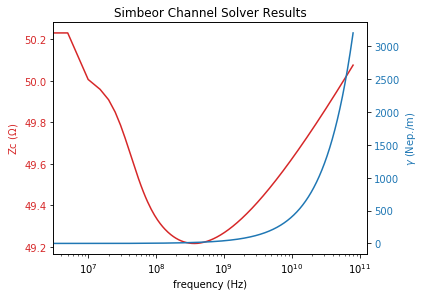

In [4]:
f  = myPyBERT.f
ix = np.where(f >= 0)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('frequency (Hz)')
ax1.set_ylabel(r'Zc ($\Omega$)', color=color)
ax1.semilogx(f[ix], abs(myPyBERT.Zc)[ix], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel(r'$\gamma$ (Nep./m)', color=color)  # we already handled the x-label with ax1
ax2.semilogx(f[ix], abs(myPyBERT.gamma)[ix], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Simbeor Channel Solver Results")
plt.show()

### Compare S[2,1] to reference.

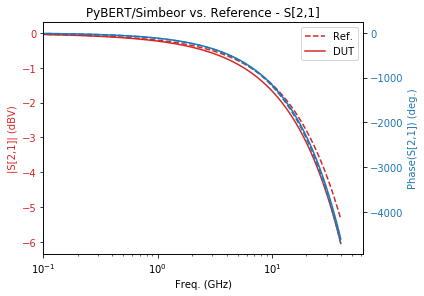

(None,)

In [5]:
fmax   = 40e9
ch_len = myPyBERT.l_ch

ntwk = rf.Network(ref_path)
f_ref  = ntwk.f
ix_ref = np.where(f_ref <= fmax)
f_dut  = myPyBERT.f
ix_dut = np.where((f_dut >= 0) & (f_dut <= fmax))

fig, ax1 = plt.subplots()
ax1.set_xlabel('Freq. (GHz)')

color = 'tab:red'
ax1.semilogx(f_ref[ix_ref]/1.e9, 20*np.log10(abs(ntwk.s[:,1,0][ix_ref])), '--',
             label="Ref.", color=color)
ax1.semilogx(f_dut[ix_dut]/1.e9, 20*np.log10(abs(np.exp(-1. * myPyBERT.gamma[ix_dut] * ch_len))),
             label="DUT",  color=color)
ax1.legend()
ax1.set_ylabel('|S[2,1]| (dBV)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.semilogx(f_ref[ix_ref]/1.e9,
             np.unwrap(np.angle(ntwk.s[:,1,0][ix_ref]))*180/np.pi, '--',
             label="Ref.", color=color)
ax2.semilogx(f_dut[ix_dut]/1.e9,
             np.unwrap(np.angle(np.exp(-1. * myPyBERT.gamma[ix_dut] * ch_len)))*180/np.pi,
             label="DUT",  color=color, )
ax2.set_ylabel('Phase(S[2,1]) (deg.)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('PyBERT/Simbeor vs. Reference - S[2,1]')
plt.axis(xmin=0.1)
plt.show(),